## Covid-Xray Pipeline Deployment in UCS

### Clone git repo

In [ ]:
! git clone -b dev https://github.com/CiscoAI/cisco-kubeflow-starter-pack.git

In [1]:
! pip install kfp --user

     |████████████████████████████████| 116 kB 17.7 MB/s eta 0:00:01
     |████████████████████████████████| 54 kB 5.4 MB/s  eta 0:00:01
     |████████████████████████████████| 51 kB 2.1 MB/s  eta 0:00:01
     |████████████████████████████████| 82 kB 2.5 MB/s  eta 0:00:01
  Created wheel for kfp: filename=kfp-1.0.0-py3-none-any.whl size=160799 sha256=42a0a146d85d3326fc19ff73a5f38bc0ef8b66e078dc6a042a246cfd2ea9ebcd
  Stored in directory: /home/jovyan/.cache/pip/wheels/a1/4d/1d/532b25d0ea5bf28d352c8973b8ce9b1d7f8f5220b236af1c62
  Created wheel for kfp-server-api: filename=kfp_server_api-1.0.0-py3-none-any.whl size=105028 sha256=ce76d880447a009d4109036d1287acdaa7c9fa141fae1d090c3de7316995aef2
  Stored in directory: /home/jovyan/.cache/pip/wheels/c9/65/08/c985cd0191974934cd16f91b4c43a83779b90e87c0773ada32
  Created wheel for strip-hints: filename=strip_hints-0.1.9-py2.py3-none-any.whl size=24671 sha256=054fbd622abf4e70ac5b09df9a87db6f1043613f63771ef9f1f5a7c74c7d05b7
  Stored in directory: 

## Restart Notebook Kernel

In [ ]:
from IPython.display import display_html
display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)

### Import libraries

In [1]:
import kfp
import os
from kubernetes import client
import calendar
import time
import numpy as np
import tensorflow
import requests, json
from PIL import Image

### Component files Declarations

In [2]:
path = 'cisco-kubeflow-starter-pack/apps/healthcare/covid/onprem/pipelines/chest-xray/' 
component_root_download= path + 'components/v2/download_dataset/'
component_root_katib= path + 'components/v2/tf-katib-deploy-service/'
component_root_train= path + 'components/v2/tf-model-train/'
component_root_serve = path + 'components/v2/tf-serving-deploy-service/'

#### Components Description

tf_train_model_op &nbsp;&nbsp;&nbsp; - &nbsp; Load dataset from nfs-volume, train Covid Xray model  and save model in nfs-volume. <br> 
tf_serve_model_op &nbsp; - &nbsp; Load Covid Xray model from nfs-volume and serve the model using tf-serving for later prediction. <br> 


### Load components from respective .YAML config files

In [3]:
tf_download_dataset_op = kfp.components.load_component_from_file(os.path.join(component_root_download, 'component.yaml'))
tf_katib = kfp.components.load_component_from_file(os.path.join(component_root_katib, 'component.yaml'))
tf_train_model_op = kfp.components.load_component_from_file(os.path.join(component_root_train, 'component.yaml')) 
tf_serve_model_op = kfp.components.load_component_from_file(os.path.join(component_root_serve, 'component.yaml'))

### Define Volume and Volume Mounts

In [4]:
nfs_pvc = client.V1PersistentVolumeClaimVolumeSource(claim_name='nfs')
nfs_volume = client.V1Volume(name='nfs', persistent_volume_claim=nfs_pvc)
nfs_volume_mount = client.V1VolumeMount(mount_path='/mnt/', name='nfs')

### Define pipeline function

In [5]:
# Creating timestamp
timestamp = str(calendar.timegm(time.gmtime()))
print(timestamp)
def covid_pipeline():
    
#     Defining Task for downloading dataset
    tf_download_task = tf_download_dataset_op()
    tf_download_task.add_volume(nfs_volume)
    tf_download_task.add_volume_mount(nfs_volume_mount)
    
#     Defining Task for katib hyperparameter values
    tf_katib_task = tf_katib(timestamp=timestamp,image="docker.io/edward1723/katib-trial:0.4")
    tf_katib_task.add_volume(nfs_volume)
    tf_katib_task.add_volume_mount(nfs_volume_mount)
    tf_katib_task.after(tf_download_task)
        
# #     Defining Task for Model training
    tf_train_model_task = tf_train_model_op(timestamp=timestamp)
    tf_train_model_task.add_volume(nfs_volume)
    tf_train_model_task.add_volume_mount(nfs_volume_mount)
    tf_train_model_task.after(tf_katib_task)
    
#     Defining Task to perform serving    
    tf_serve_model_task = tf_serve_model_op(timestamp=timestamp)
    tf_serve_model_task.add_volume(nfs_volume)
    tf_serve_model_task.add_volume_mount(nfs_volume_mount)
    tf_serve_model_task.after(tf_train_model_task)
    
#Creating a pipeline run
kfp.Client().create_run_from_pipeline_func(covid_pipeline, arguments={})

1599127796


RunPipelineResult(run_id=13ffd608-8baf-4781-b2f4-3553c855feda)

## Run a predictrion 

###  Get TF Serving IP and Port

In [6]:
%%bash -s "$timestamp" --out IP_PORT
echo "$(kubectl get svc -n kubeflow -l timestamp=ts-$1 -o=jsonpath='{.items[0].spec.clusterIP}')"
echo "$(kubectl get svc -n kubeflow -l timestamp=ts-$1 -o=jsonpath='{.items[0].spec.ports[1].port}')"

###  Data preprocessing & prediction

In [8]:
#Client data preprocess function
def preprocess(image_path):
    sess = tensorflow.keras.backend.get_session()
    img = tensorflow.read_file(image_path)
    img = tensorflow.image.decode_jpeg(img, channels=3)
    img.set_shape([None, None, 3])
    img = tensorflow.image.resize_images(img, (224, 224))
    img = img.eval(session=sess) # convert to numpy array
    img = np.expand_dims(img, 0) # make 'batch' of 1
    return img

# Function to predict chest-xray data
def predict(data):
    
    headers = {"content-type": "application/json"}
    data={"signature_name": "serving_default", "instances": data.tolist()}
    url="http://%s:%s/v1/models/Model_Covid:predict"%(IP_PORT.split("\n")[0], IP_PORT.split("\n")[1])
    json_response = requests.post(url, data=json.dumps(data), headers=headers)
    prediction=json_response.json()['predictions']
    labels=[1,0]
    pred = labels[np.argmax(prediction)]
    diction = {'0':'NORMAL','1':'COVID'}
    result = diction[str(pred)]
    print('Xray result : ',result)

    baseheight = 300
    img_output = Image.open(test_image_path)
    hpercent = (baseheight / float(img_output.size[1]))
    wsize = int((float(img_output.size[0]) * float(hpercent)))
    img_res = img_output.resize((wsize, baseheight), Image.ANTIALIAS)
    return img_res

Xray result :  COVID


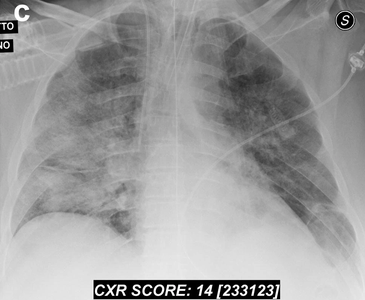

In [11]:
#Call client data preprocess function
img_data=preprocess("katib_data/covid/16654_2_1.jpg")

#Call predict function
predict(img_data)